# Real Estate Modelling
## EDA and model building to predict real estate prices
---

The following context has been provided by the Microsoft Learn platform, the repository for which can be found <a href="https://github.com/MicrosoftDocs/ml-basics/blob/master/challenges/02%20-%20Real%20Estate%20Regression%20Challenge.ipynb">here</a>.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

## Section 1: Exploratory Data Analysis
We begin by importing and analysing the dataset, looking to identify features that contribute meaningfully to the sale price of a plot of land. This involves playing around with statistical overviews and various plots to help us identify important features.

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/MicrosoftDocs/ml-basics/master/challenges/data/real_estate.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   transaction_date          414 non-null    float64
 1   house_age                 414 non-null    float64
 2   transit_distance          414 non-null    float64
 3   local_convenience_stores  414 non-null    int64  
 4   latitude                  414 non-null    float64
 5   longitude                 414 non-null    float64
 6   price_per_unit            414 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 22.8 KB


In [3]:
data.nunique()

transaction_date             12
house_age                   236
transit_distance            259
local_convenience_stores     11
latitude                    234
longitude                   232
price_per_unit              270
dtype: int64

In [4]:
data.head()

,transaction_date,house_age,transit_distance,local_convenience_stores,latitude,longitude,price_per_unit
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [5]:
data.tail()

,transaction_date,house_age,transit_distance,local_convenience_stores,latitude,longitude,price_per_unit
409,2013.000,13.7,4082.01500,0,24.94155,121.50381,15.4
410,2012.667,5.6,90.45606,9,24.97433,121.54310,50.0
411,2013.250,18.8,390.96960,7,24.97923,121.53986,40.6
412,2013.000,8.1,104.81010,5,24.96674,121.54067,52.5
413,2013.500,6.5,90.45606,9,24.97433,121.54310,63.9


In [6]:
data.shape

(414, 7)

In [7]:
data.describe()

,transaction_date,house_age,transit_distance,local_convenience_stores,latitude,longitude,price_per_unit
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148971,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,0.281967,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.917000,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,2013.167000,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,2013.417000,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,2013.583000,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


In [8]:
data.isnull().sum()

transaction_date            0
house_age                   0
transit_distance            0
local_convenience_stores    0
latitude                    0
longitude                   0
price_per_unit              0
dtype: int64

No null values, which makes our preprocessing a lot simpler.

<AxesSubplot:>

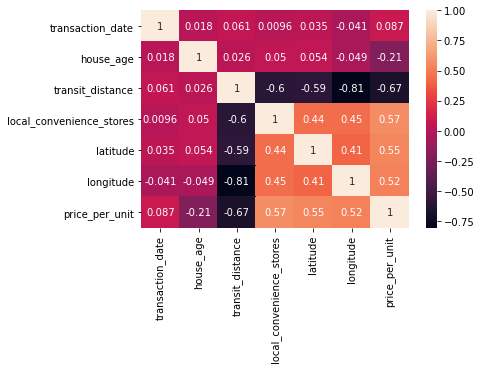

In [9]:
correlation = data.corr()
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True)

It appears as though there's little correlation between transaction date and price per unit, which makes sense in this dataset, given that the dates aren't spread the far apart. I find it surprising that the age of the house doesn't affect the price much either, although it makes sense that this wouldn't matter much to the average property buyer. Our more important features affecting price appear to be the distance from local convenience stores, geographical loccation and travel distance.

In [10]:
# extract features deemed important and separate target variable
columns = ['transit_distance', 'local_convenience_stores', 'latitude', 'longitude']
prices = data.price_per_unit

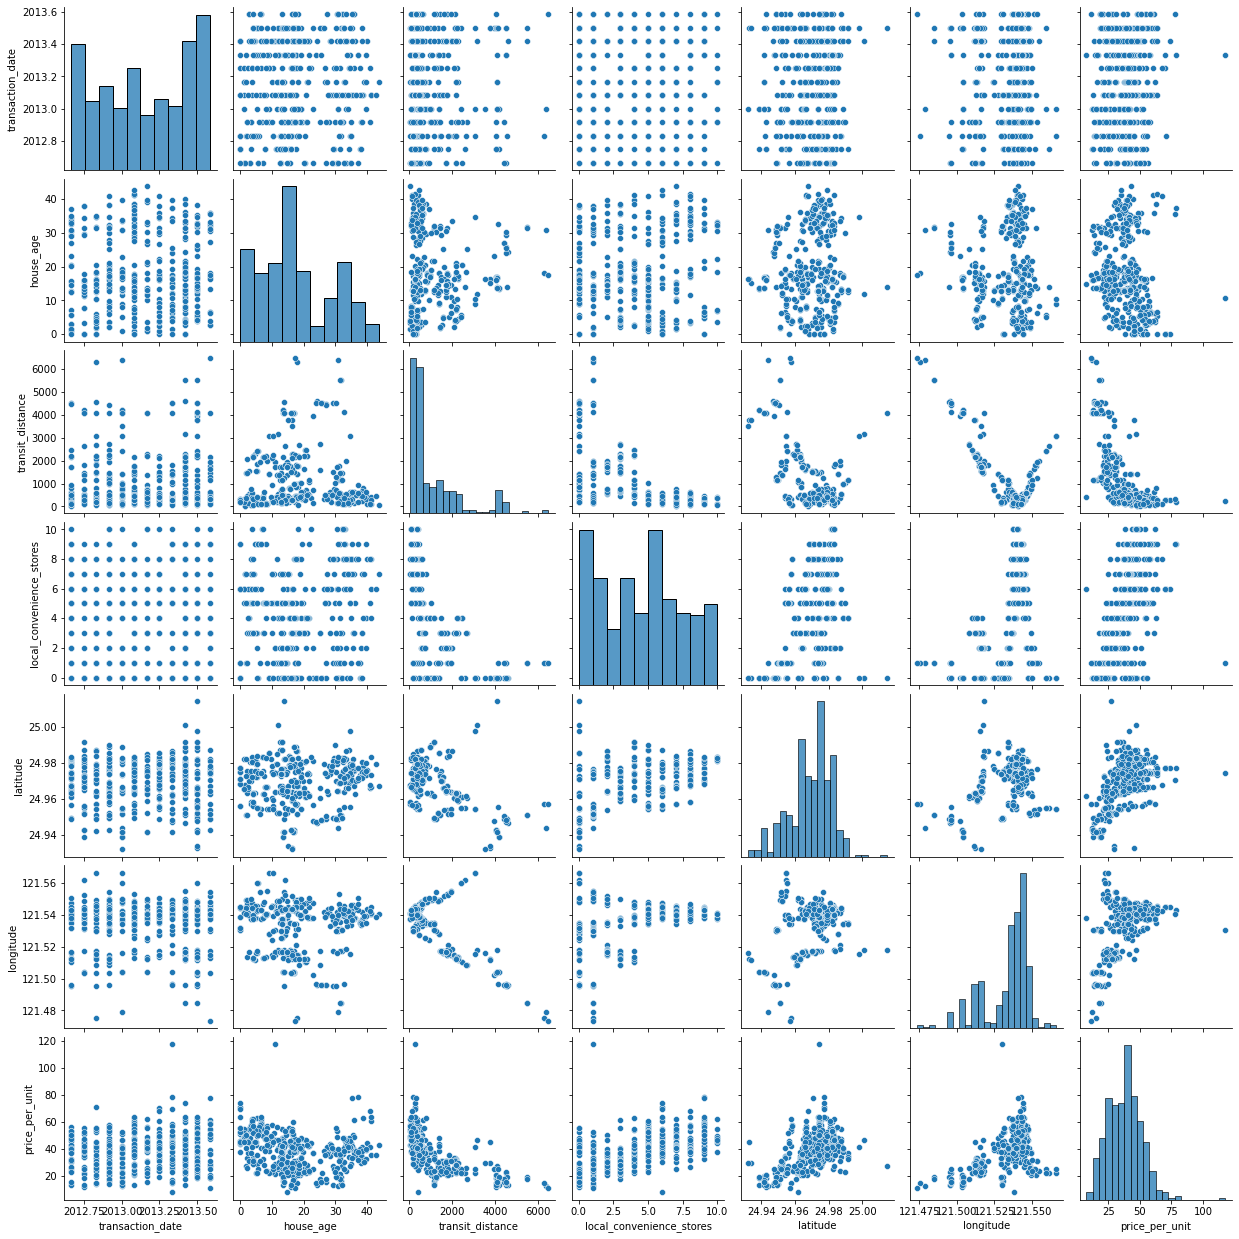

In [11]:
sns.pairplot(data)

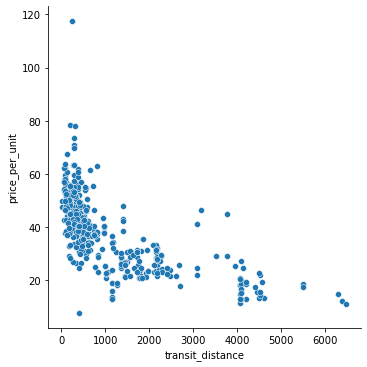

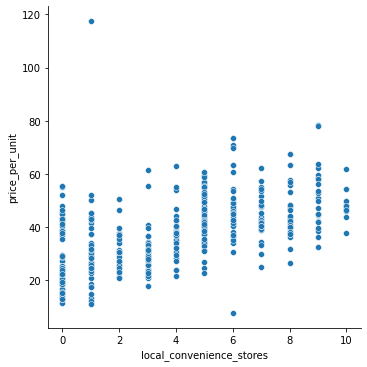

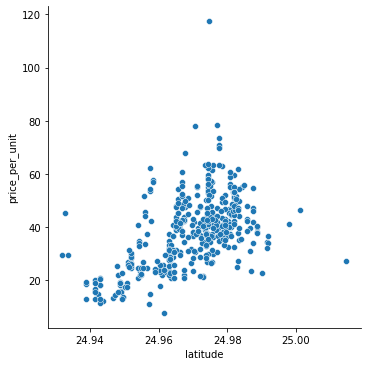

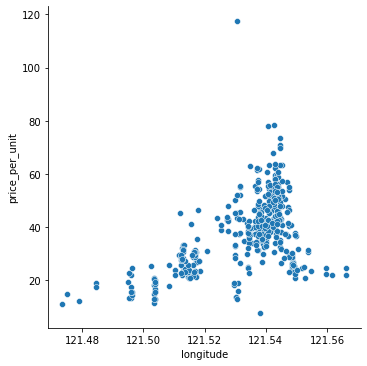

In [12]:
for col in columns:
    sns.relplot(x=col, y=prices, data=data)

### Data preprocessing

Given our analysis, I will drop the first two columns of the dataset so that our model can focus on learning the more prominent features:

In [13]:
data_new = data.drop(['transaction_date', 'house_age'], axis=1)

data_new.head()

,transit_distance,local_convenience_stores,latitude,longitude,price_per_unit
0,84.87882,10,24.98298,121.54024,37.9
1,306.59470,9,24.98034,121.53951,42.2
2,561.98450,5,24.98746,121.54391,47.3
3,561.98450,5,24.98746,121.54391,54.8
4,390.56840,5,24.97937,121.54245,43.1


We will also apply one-hot encoding to help the model learn the 'local_convenience_stores' values more easily. Given the (slight) weak correlation between this column and the prices, I hope this will yield some interesting results from our model.

In [14]:
enc = OneHotEncoder(handle_unknown='ignore')
conven_enc = pd.DataFrame(enc.fit_transform(data_new[['local_convenience_stores']]).toarray())

In [15]:
# merge with modified dataframe on key values
data_new = data_new.join(conven_enc)

data_new.head()

,transit_distance,local_convenience_stores,latitude,longitude,price_per_unit,0,1,2,3,4,5,6,7,8,9,10
0,84.87882,10,24.98298,121.54024,37.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,306.59470,9,24.98034,121.53951,42.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,561.98450,5,24.98746,121.54391,47.3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,561.98450,5,24.98746,121.54391,54.8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,390.56840,5,24.97937,121.54245,43.1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [16]:
data_enc = data_new.drop('local_convenience_stores', axis=1)
data_enc.head()

,transit_distance,latitude,longitude,price_per_unit,0,1,2,3,4,5,6,7,8,9,10
0,84.87882,24.98298,121.54024,37.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,306.59470,24.98034,121.53951,42.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,561.98450,24.98746,121.54391,47.3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,561.98450,24.98746,121.54391,54.8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,390.56840,24.97937,121.54245,43.1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Modelling

Now that we've conduced our EDA and data processing, it's time to build some models and evaluate their performance.

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score

In [31]:
X, y = data_enc[['transit_distance', 'latitude', 'longitude', 0,1,2,3,4,5,6,7,8,9,10]].values, data_enc['price_per_unit'].values

In [ ]:
'''
# random forest regressor pipeline
rfr_pipeline = Pipeline(steps = [['rfr', RandomForestRegressor()]])
# k fold
rfr_kfold = KFold(n_splits=5, shuffle=True, random_state=101)
# hyperparameter tuning was carried out and optimal hyperparameters were selected and implemented to reduce runtime
rfr_param_grid = {
    'rfr__max_depth': [4], 
    'rfr__max_features': ['auto'], 
    'rfr__n_estimators': [200],
    'rfr__min_samples_split': [3],
    'rfr__min_samples_leaf': [4]
                 }
# grid search cv to observe learning curve
rfr_grid_search = GridSearchCV(estimator=rfr_pipeline, param_grid=rfr_param_grid, cv=rfr_kfold, 
                                    return_train_score=True, scoring='neg_mean_squared_error')
# fitting to the train data
rfr_grid_search.fit(X_train, y_train)
'''